In [1]:
import os
import numpy as np 
import pandas as pd
from PromoterStrengthPrediction_Fun import *
import matplotlib.pyplot as plt

### Data loading

In [2]:
file_save_path = os.path.dirname(os.getcwd())+'/result'
PromoterData, _, _ = data_import()
PromoterDataset = data_preprocessed(PromoterData)
PromoterSequence = [seq[0] for seq in PromoterDataset]
PromoterStrength = [seq[1] for seq in PromoterDataset]

### Promoter strength histogram

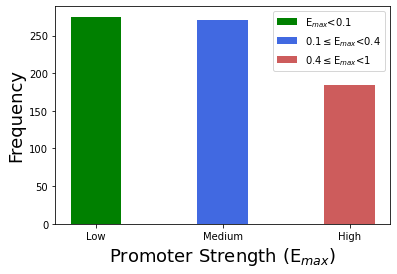

In [3]:
Low_PromoterSequence = [seq[0] for seq in PromoterDataset if seq[1] == 0]
Low_PromoterStrength = [0]*len(Low_PromoterSequence)
Medium_PromoterSequence = [seq[0] for seq in PromoterDataset if seq[1] == 1]
Medium_PromoterStrength = [1]*len(Medium_PromoterSequence)
High_PromoterSequence = [seq[0] for seq in PromoterDataset if seq[1] == 2]
High_PromoterStrength = [2]*len(High_PromoterSequence)

plt.figure()
plt.hist(Low_PromoterStrength, bins=np.arange(4)-0.5, rwidth=0.4, color='green')
plt.hist(Medium_PromoterStrength, bins=np.arange(4)-0.5, rwidth=0.4, color='royalblue')
plt.hist(High_PromoterStrength, bins=np.arange(4)-0.5, rwidth=0.4, color='indianred')
plt.xticks([])
plt.xlabel('Promoter Strength (E${_{max}}$)', fontsize=18)
plt.xticks([0,1,2], ['Low','Medium','High'])
plt.ylabel('Frequency', fontsize=18)
plt.legend(['E${_{max}}$<0.1', '0.1${\leq}$E${_{max}}$<0.4', '0.4${\leq}$E${_{max}}$<1'])
plt.show()

### Position Information Gain

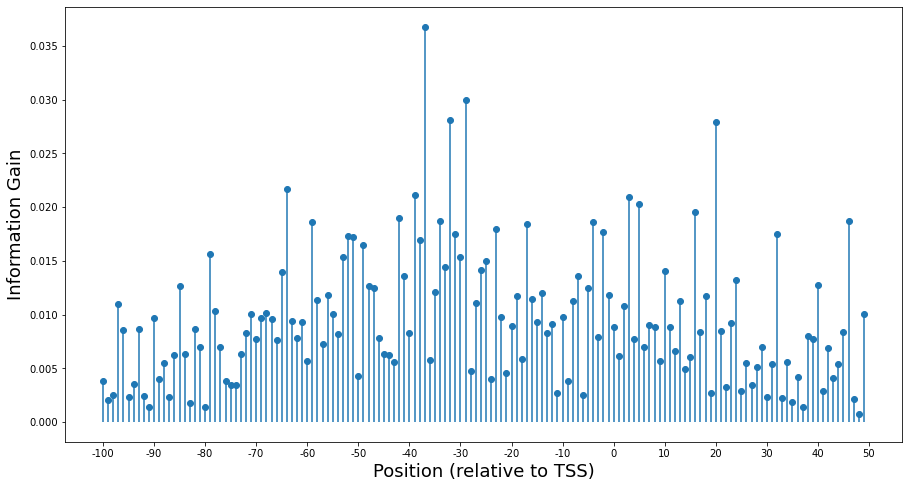

In [4]:
from scipy.stats import entropy
sample_Num = len(PromoterSequence)
sequence_Length = len(PromoterSequence[0])
PositionEntropy = np.zeros([sequence_Length])
value_Label, counts_Label = np.unique(PromoterStrength, return_counts=True)
LabelEntropy = entropy(counts_Label, base=2)
for i in range(sequence_Length):
    A_Label = []
    T_Label = []
    C_Label = []
    G_Label = []
    for j in range(sample_Num):
        if PromoterSequence[j][i] == 'A':
            A_Label.append(PromoterStrength[j])
        elif PromoterSequence[j][i] == 'T':
            T_Label.append(PromoterStrength[j])
        elif PromoterSequence[j][i] == 'C':
            C_Label.append(PromoterStrength[j])
        else:
            G_Label.append(PromoterStrength[j])
    value_A_Label, counts_A_Label = np.unique(A_Label, return_counts=True)
    value_T_Label, counts_T_Label = np.unique(T_Label, return_counts=True)
    value_C_Label, counts_C_Label = np.unique(C_Label, return_counts=True)
    value_G_Label, counts_G_Label = np.unique(G_Label, return_counts=True)
    PositionEntropy[i] = LabelEntropy-(len(A_Label)/sample_Num*entropy(counts_A_Label, base=2)+len(T_Label)/sample_Num*entropy(counts_T_Label, base=2)+len(C_Label)/sample_Num*entropy(counts_C_Label, base=2)+len(G_Label)/sample_Num*entropy(counts_G_Label, base=2))

plt.figure(figsize=(15, 8))
plt.stem(np.arange(-len(PositionEntropy),0,1), PositionEntropy, basefmt=' ', use_line_collection=True)
x = range(-150, 10, 10)
plt.xticks(x, ['-100', '-90', '-80', '-70', '-60', '-50', '-40', '-30', '-20', '-10', '0', '10', '20', '30', '40', '50'])
plt.xlabel('Position (relative to TSS)', fontsize=18)
plt.ylabel('Information Gain', fontsize=18)
plt.show()

### ROC curve and AUC - Parameters optimization
LR = 0.1, P = [0.1, 0.15, 0.21, 0.28, 0.36]

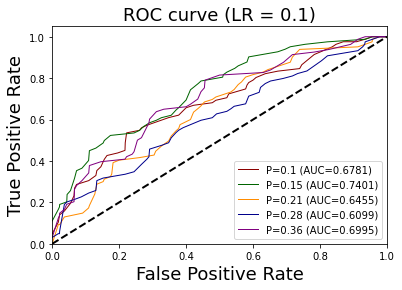

In [5]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def get_roc_auc(trues, preds, label, color):
  labels = [0,1,2]
  nb_classes = len(labels)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(nb_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
  mean_tpr /= nb_classes
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
  # Plot all ROC curves
  plt.plot(fpr["macro"], tpr["macro"], label=label+' (AUC={0:0.4f})'.format(roc_auc["macro"]), color=color, linestyle='-', linewidth=1)
  
r1 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.1, 0.1), allow_pickle=True)
r2 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.15, 0.1), allow_pickle=True)
r3 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.21, 0.1), allow_pickle=True)
r4 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.28, 0.1), allow_pickle=True)
r5 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.36, 0.1), allow_pickle=True)
test_trues = r1['test_truesls']
test_trues = label_binarize(test_trues, classes=[i for i in range(3)])
test_preds1 = r1['test_predsls']
test_preds2 = r2['test_predsls']
test_preds3 = r3['test_predsls']
test_preds4 = r4['test_predsls']
test_preds5 = r5['test_predsls']

lw = 2
plt.figure()
get_roc_auc(test_trues, test_preds1, 'P=0.1', 'darkred')
get_roc_auc(test_trues, test_preds2, 'P=0.15', 'darkgreen')
get_roc_auc(test_trues, test_preds3, 'P=0.21', 'darkorange')
get_roc_auc(test_trues, test_preds4, 'P=0.28', 'darkblue')
get_roc_auc(test_trues, test_preds5, 'P=0.36', 'purple')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve (LR = 0.1)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

LR = 0.01, P = [0.1, 0.15, 0.21, 0.28, 0.36]

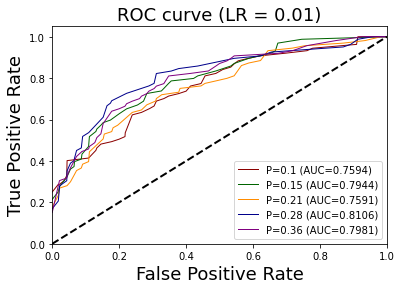

In [6]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def get_roc_auc(trues, preds, label, color):
  labels = [0,1,2]
  nb_classes = len(labels)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(nb_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
  mean_tpr /= nb_classes
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
  # Plot all ROC curves
  plt.plot(fpr["macro"], tpr["macro"], label=label+' (AUC={0:0.4f})'.format(roc_auc["macro"]), color=color, linestyle='-', linewidth=1)
  
r1 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.1, 0.01), allow_pickle=True)
r2 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.15, 0.01), allow_pickle=True)
r3 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.21, 0.01), allow_pickle=True)
r4 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.28, 0.01), allow_pickle=True)
r5 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.36, 0.01), allow_pickle=True)
test_trues = r1['test_truesls']
test_trues = label_binarize(test_trues, classes=[i for i in range(3)])
test_preds1 = r1['test_predsls']
test_preds2 = r2['test_predsls']
test_preds3 = r3['test_predsls']
test_preds4 = r4['test_predsls']
test_preds5 = r5['test_predsls']

lw = 2
plt.figure()
get_roc_auc(test_trues, test_preds1, 'P=0.1', 'darkred')
get_roc_auc(test_trues, test_preds2, 'P=0.15', 'darkgreen')
get_roc_auc(test_trues, test_preds3, 'P=0.21', 'darkorange')
get_roc_auc(test_trues, test_preds4, 'P=0.28', 'darkblue')
get_roc_auc(test_trues, test_preds5, 'P=0.36', 'purple')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve (LR = 0.01)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

LR = 0.001, P = [0.1, 0.15, 0.21, 0.28, 0.36]

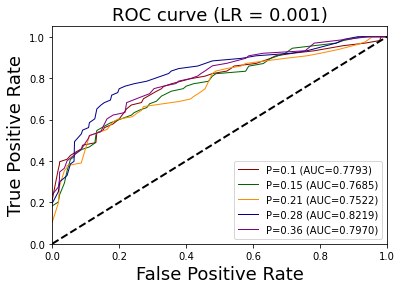

In [7]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def get_roc_auc(trues, preds, label, color):
  labels = [0,1,2]
  nb_classes = len(labels)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(nb_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
  mean_tpr /= nb_classes
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
  # Plot all ROC curves
  plt.plot(fpr["macro"], tpr["macro"], label=label+' (AUC={0:0.4f})'.format(roc_auc["macro"]), color=color, linestyle='-', linewidth=1)
  
r1 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.1, 0.001), allow_pickle=True)
r2 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.15, 0.001), allow_pickle=True)
r3 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.21, 0.001), allow_pickle=True)
r4 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.28, 0.001), allow_pickle=True)
r5 = np.load(file_save_path+'/y_predict_P_{}_LR_{}.npz'.format(0.36, 0.001), allow_pickle=True)
test_trues = r1['test_truesls']
test_trues = label_binarize(test_trues, classes=[i for i in range(3)])
test_preds1 = r1['test_predsls']
test_preds2 = r2['test_predsls']
test_preds3 = r3['test_predsls']
test_preds4 = r4['test_predsls']
test_preds5 = r5['test_predsls']

lw = 2
plt.figure()
get_roc_auc(test_trues, test_preds1, 'P=0.1', 'darkred')
get_roc_auc(test_trues, test_preds2, 'P=0.15', 'darkgreen')
get_roc_auc(test_trues, test_preds3, 'P=0.21', 'darkorange')
get_roc_auc(test_trues, test_preds4, 'P=0.28', 'darkblue')
get_roc_auc(test_trues, test_preds5, 'P=0.36', 'purple')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve (LR = 0.001)', fontsize=18)
plt.legend(loc="lower right")
plt.show()

### ROC curve and AUC - Different input modalities

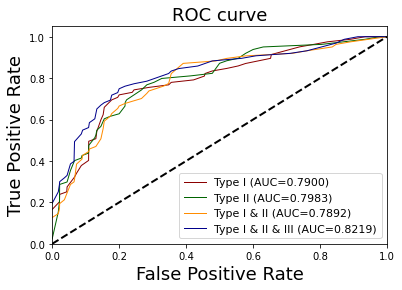

In [8]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def get_roc_auc(trues, preds, label, color):
  labels = [0,1,2]
  nb_classes = len(labels)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(nb_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
  mean_tpr /= nb_classes
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
  # Plot all ROC curves
  plt.plot(fpr["macro"], tpr["macro"], label=label+' (AUC={0:0.4f})'.format(roc_auc["macro"]), color=color, linestyle='-', linewidth=1)
  
r1 = np.load(file_save_path+'/y_predict_P_0.28_LR_0.001_NC.npz', allow_pickle=True)
r2 = np.load(file_save_path+'/y_predict_P_0.28_LR_0.001_TriC.npz', allow_pickle=True)
r3 = np.load(file_save_path+'/y_predict_P_0.28_LR_0.001_NTriC.npz', allow_pickle=True)
r4 = np.load(file_save_path+'/y_predict_P_0.28_LR_0.001_ALL.npz', allow_pickle=True)

test_trues = r1['test_truesls']
test_trues = label_binarize(test_trues, classes=[i for i in range(3)])
test_preds1 = r1['test_predsls']
test_preds2 = r2['test_predsls']
test_preds3 = r3['test_predsls']
test_preds4 = r4['test_predsls']

lw = 2
plt.figure()
get_roc_auc(test_trues, test_preds1, 'Type I', 'darkred')
get_roc_auc(test_trues, test_preds2, 'Type II', 'darkgreen')
get_roc_auc(test_trues, test_preds3, 'Type I & II', 'darkorange')
get_roc_auc(test_trues, test_preds4, 'Type I & II & III', 'darkblue')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right", fontsize=11)
plt.show()

### ROC curve and AUC - Different encoding methods

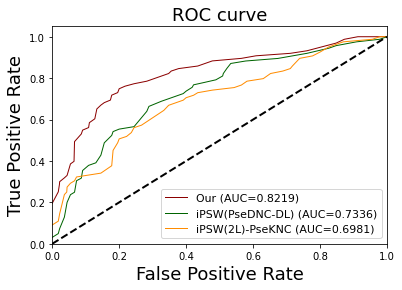

In [9]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def get_roc_auc(trues, preds, label, color):
  labels = [0,1,2]
  nb_classes = len(labels)
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(nb_classes):
    fpr[i], tpr[i], _ = roc_curve(trues[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(nb_classes)]))
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(nb_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
  mean_tpr /= nb_classes
  fpr["macro"] = all_fpr
  tpr["macro"] = mean_tpr
  roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
  # Plot all ROC curves
  plt.plot(fpr["macro"], tpr["macro"], label=label+' (AUC={0:0.4f})'.format(roc_auc["macro"]), color=color, linestyle='-', linewidth=1)
  
r1 = np.load(file_save_path+'/y_predict_P_0.28_LR_0.001_ALL.npz', allow_pickle=True)
r2 = np.load(file_save_path+'/y_predict_P_0.28_LR_0.001_DNC.npz', allow_pickle=True)
r3 = np.load(file_save_path+'/y_predict_C_1_g_0.0001_PseKNC.npz', allow_pickle=True)

test_trues = r1['test_truesls']
test_trues = label_binarize(test_trues, classes=[i for i in range(3)])
test_preds1 = r1['test_predsls']
test_preds2 = r2['test_predsls']
test_preds3 = r3['test_predsls']

lw = 2
plt.figure()
get_roc_auc(test_trues, test_preds1, 'Our', 'darkred')
get_roc_auc(test_trues, test_preds2, 'iPSW(PseDNC-DL)', 'darkgreen')
get_roc_auc(test_trues, test_preds3, 'iPSW(2L)-PseKNC', 'darkorange')

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve', fontsize=18)
plt.legend(loc="lower right", fontsize=11)
plt.show()